In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
with open("query.sql", "r") as query:
    sql_query: str = query.read()

## checkout_1.csv

In [3]:
df = pd.read_csv(
    "../data/checkout_1.csv",
    dtype={
        "time": str,
        "today": np.int8,
        "yesterday": np.int8,
        "same_day_last_week": np.int8,
        "avg_last_week": np.float64,
        "avg_last_month": np.float64,
    },
)
with duckdb.connect(database=":memory:", read_only=False) as con:
    con.execute("CREATE TABLE checkout AS SELECT * FROM df")
    df_checkout_1 = con.execute(sql_query).fetch_df()
df_checkout_1.head()

,hour,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,pct_vs_yesterday,pct_vs_same_day_last_week,pct_vs_avg_last_week,pct_vs_avg_last_month,anomaly_flag
0,0,00h,9,12,11,6.42,4.85,-25.0,-18.18,40.19,85.57,ok
1,1,01h,3,5,1,1.85,1.92,-40.0,200.00,62.16,56.25,ok
2,2,02h,1,0,0,0.28,0.82,NaN,NaN,257.14,21.95,ok
3,3,03h,1,0,0,0.42,0.46,NaN,NaN,138.10,117.39,spike
4,4,04h,0,0,1,0.42,0.21,NaN,-100.00,-100.00,-100.00,drop


In [4]:
spikes = df_checkout_1[df_checkout_1["anomaly_flag"] == "spike"]
drops = df_checkout_1[df_checkout_1["anomaly_flag"] == "drop"]

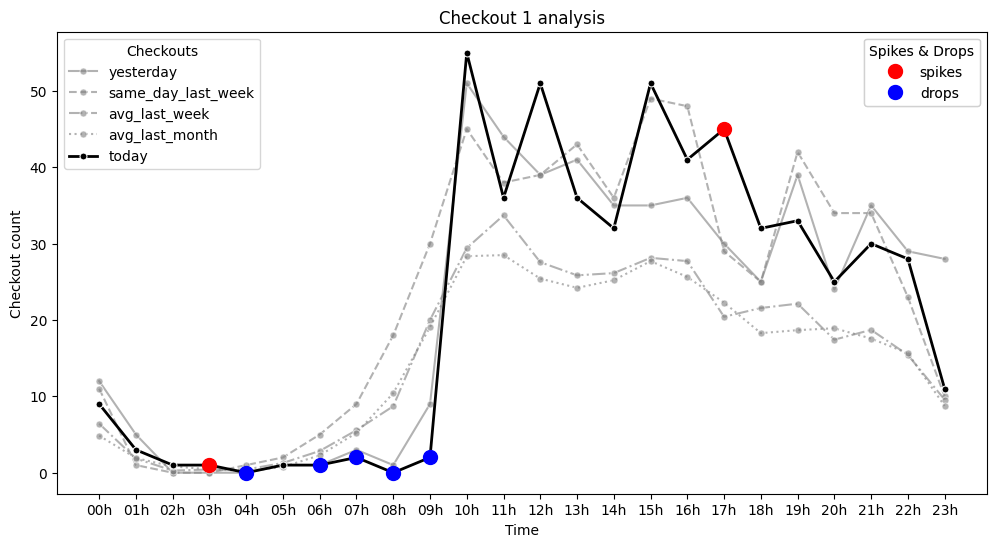

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=df_checkout_1,
    x="time",
    y="yesterday",
    ax=ax,
    label="yesterday",
    color="grey",
    marker="o",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_1,
    x="time",
    y="same_day_last_week",
    ax=ax,
    label="same_day_last_week",
    color="grey",
    marker="o",
    linestyle="--",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_1,
    x="time",
    y="avg_last_week",
    ax=ax,
    label="avg_last_week",
    color="grey",
    marker="o",
    linestyle="-.",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_1,
    x="time",
    y="avg_last_month",
    ax=ax,
    label="avg_last_month",
    color="grey",
    marker="o",
    linestyle=":",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_1,
    x="time",
    y="today",
    ax=ax,
    label="today",
    lw=2,
    color="black",
    marker="o",
    markersize=5,
)
ax.plot(
    spikes["time"],
    spikes["today"],
    marker="o",
    color="red",
    label="spikes",
    linestyle="",
    markersize=10,
)
ax.plot(
    drops["time"],
    drops["today"],
    marker="o",
    color="blue",
    label="drops",
    linestyle="",
    markersize=10,
)

ax.set(ylabel="Checkout count", xlabel="Time", title="Checkout 1 analysis")

handles, labels = ax.get_legend_handles_labels()
line_legend = ax.legend(
    loc="upper left", handles=handles[:5], labels=labels[:5], title="Checkouts"
)
spikes_drops_legend = ax.legend(
    loc="upper right", handles=handles[5:], labels=labels[5:], title="Spikes & Drops"
)
ax.add_artist(line_legend)
ax.add_artist(spikes_drops_legend)
plt.savefig("../graphs/checkout_1.png", format="png", dpi=300, bbox_inches="tight")

##### Analysis

Early Morning (00h – 05h)

- Checkout behavior remained **consistent and stable**. The marks on the graph will be discussed below. 
- In the graph, the single checkout at 03h is pointed out as a spike, but this is a consequence of both last week and month averages being too low at these times (< 1). It problably isn't an anomaly.
- At 04h, there was no checkouts, which is expected given the low averages (< 1) at this time.

Morning drop (06h - 09h) - **anomaly candidate** 

- Checkouts considerably smaller than what was expected. Specially, at 08h when no checkouts were registered.
- **06h anomaly**:
  - Today: **1 checkout**
  - Expected: 2-3 checkouts (last week/month avgs)
- **07h anomaly**:
  - Today: **1 checkout**
  - Expected: ~5 checkouts (last week/month avgs)
- **08h anomaly**:
  - Today: **0 checkouts**
  - Weekly avg: **8.7**
  - Monthly avg: **10.4**
  - Yesterday: **1 checkout**
- **09h anomaly**:
  - Today: **2 checkouts**
  - Expected: ~20 (last week/month avgs)
- This suggests a **short-term operational issue** (last 2 days), not a long-term trend, since it did not appear last week but was also reflected yesterday, in particular from 06h to 08h.

---

Peak Build-up (10h – 11h)

- **10h peak (today)**: **55 checkouts**
  - +86.9% vs weekly avg (29.4)  
  - +93.9% vs monthly avg (28.3)
  - +7.8% vs yesterday (51)
  - +13% vs the same day last week (45)  
- Normally, peak occurs at **11h (avg 33.7)** → today shifted **1h earlier**.
  - In line with yesterday and the same day last week. May suggest a recent behavioral change.

---

Afternoon (12h – 17h) - **anomaly candidates**

- Consistently **above both averages** across multiple hours:  
  - **12h**: 51 checkouts → +85% vs weekly avg (27.6), +100% vs monthly avg (25.4), +31% vs yesterday and the same day last week (39)    
  - **15h**: 51 checkouts → +81% vs weekly avg (28.1), +84% vs monthly avg (27.7), +46% vs yesterday (35), +4% vs the same day last week (49)  
  - **17h**: 45 checkouts → +120% vs weekly avg (20.4), +102% vs monthly avg (22.3), +50% vs yesterday (30), +55% vs the same day last week    
- The 12h peak is well above both averages, **moderate anomaly** 
- The 15h peak is aligned with last week's 49 checkouts on the same day -> likely not an anomaly, but a weekly pattern.
- 17h peak well above any other day, **strong anomaly**. 

---

Evening (18h – 22h)

- Checkouts remained **well above historical averages**, but in line with yesterday and the same day last week.
- May indicate a baseline shift.

---

**Possible Anomalies**
- **Critical**: 06h – 09h drop; 17h spike.
- **Moderate**: 12h.   
- **Seasonal** (likely not an anomaly): 15h.

---


## checkout_2.csv

In [6]:
df = pd.read_csv(
    "../data/checkout_2.csv",
    dtype={
        "time": str,
        "today": np.int8,
        "yesterday": np.int8,
        "same_day_last_week": np.int8,
        "avg_last_week": np.float64,
        "avg_last_month": np.float64,
    },
)
with duckdb.connect(database=":memory:", read_only=False) as con:
    con.execute("CREATE TABLE checkout AS SELECT * FROM df")
    df_checkout_2 = con.execute(sql_query).fetch_df()
df_checkout_2.head()

,hour,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,pct_vs_yesterday,pct_vs_same_day_last_week,pct_vs_avg_last_week,pct_vs_avg_last_month,anomaly_flag
0,0,00h,6,9,5,5.00,4.92,-33.33,20.0,20.00,21.95,ok
1,1,01h,3,3,2,2.00,1.92,0.00,50.0,50.00,56.25,ok
2,2,02h,3,1,2,0.42,0.75,200.00,50.0,614.29,300.00,spike
3,3,03h,0,1,1,0.42,0.46,-100.00,-100.0,-100.00,-100.00,drop
4,4,04h,0,0,0,0.14,0.21,NaN,NaN,-100.00,-100.00,drop


In [7]:
spikes = df_checkout_2[df_checkout_2["anomaly_flag"] == "spike"]
drops = df_checkout_2[df_checkout_2["anomaly_flag"] == "drop"]

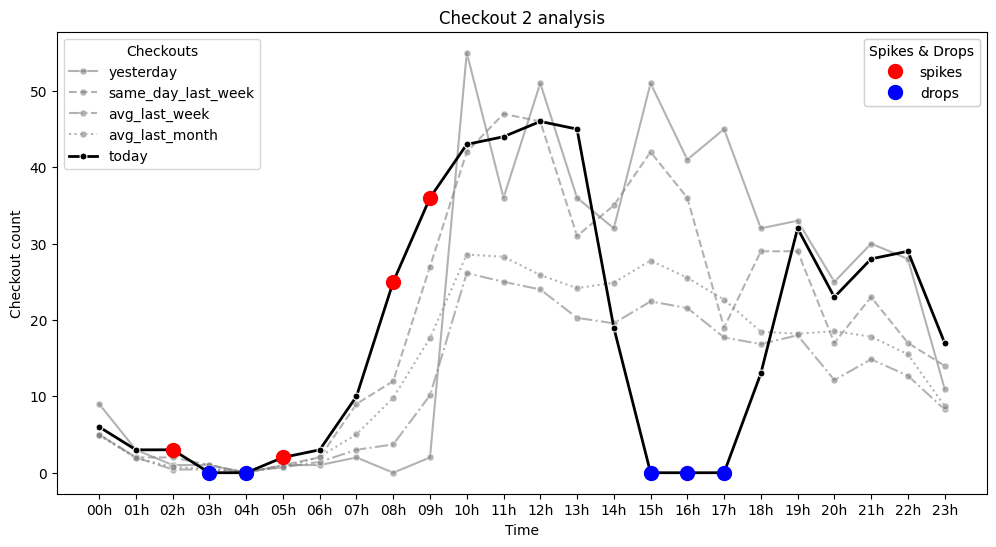

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=df_checkout_2,
    x="time",
    y="yesterday",
    ax=ax,
    label="yesterday",
    color="grey",
    marker="o",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_2,
    x="time",
    y="same_day_last_week",
    ax=ax,
    label="same_day_last_week",
    color="grey",
    marker="o",
    linestyle="--",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_2,
    x="time",
    y="avg_last_week",
    ax=ax,
    label="avg_last_week",
    color="grey",
    marker="o",
    linestyle="-.",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_2,
    x="time",
    y="avg_last_month",
    ax=ax,
    label="avg_last_month",
    color="grey",
    marker="o",
    linestyle=":",
    alpha=0.6,
    markersize=5,
)
sns.lineplot(
    data=df_checkout_2,
    x="time",
    y="today",
    ax=ax,
    label="today",
    lw=2,
    color="black",
    marker="o",
    markersize=5,
)
ax.plot(
    spikes["time"],
    spikes["today"],
    marker="o",
    color="red",
    label="spikes",
    linestyle="",
    markersize=10,
)
ax.plot(
    drops["time"],
    drops["today"],
    marker="o",
    color="blue",
    label="drops",
    linestyle="",
    markersize=10,
)
ax.set(ylabel="Checkout count", xlabel="Time", title="Checkout 2 analysis")
handles, labels = ax.get_legend_handles_labels()
line_legend = ax.legend(
    loc="upper left", handles=handles[:5], labels=labels[:5], title="Checkouts"
)
spikes_drops_legend = ax.legend(
    loc="upper right", handles=handles[5:], labels=labels[5:], title="Spikes & Drops"
)
ax.add_artist(line_legend)
ax.add_artist(spikes_drops_legend)
plt.savefig("../graphs/checkout_2.png", format="png", dpi=300, bbox_inches="tight")


##### Analysis

### Early Morning (00h – 06h)

- Checkout behavior remained **consistent and stable**.  
- The 3 checkouts at 02h and the 2 at 05h are flagged as spikes, but these likely reflect **low historical baselines** (< 1 checkout) rather than real anomalies.  
- At 03h and 04h, no checkouts occurred — which is expected given the historically low averages.  

---

### Morning Spikes (07h – 09h) — **Anomaly Candidates**

- Checkouts show a **clear deviation** from expectations.  

**07h — Moderate Anomaly**  
- Today: **10 checkouts**  
- Expected: 3–5 checkouts (weekly/monthly averages)  
- Yesterday: 2 checkouts (possibly anomalous baseline)  

**08h — Strong Anomaly**  
- Today: **25 checkouts**  
- Weekly avg: **3.71 checkouts** (+573%)  
- Monthly avg: **9.82 checkouts** (+155%)  
- Same day last week: **12 checkouts** (+108%)  
- Yesterday: **0 checkouts** (anomalous)  

**09h — Strong Anomaly**  
- Today: **36 checkouts**  
- Expected: **10–17 checkouts** (weekly/monthly averages) → > +100% deviation  
- Same day last week: **27 checkouts** (+33%)  
- Yesterday: **2 checkouts** (anomalous)  

---

### Midday Peak (10h – 13h)

- Checkout levels remained **well above weekly/monthly averages**,  
- but aligned with yesterday and the same day last week.  
- Suggests a **baseline shift** rather than a temporary anomaly.  

---

### Afternoon (14h – 18h) — **Anomaly Candidates**

- **14h:** 19 checkouts  
  - Slightly below averages (19.5–24.9)  
  - Considerably lower than yesterday (32) and last week (35).  

- **15h – 17h:** **No checkouts registered → Strong anomaly candidate.**  

- **18h:** 13 checkouts, indicating **possible reestablishment of data collection**.  

---

### Evening (19h – 23h)

- Checkouts stayed **above historical averages**,  
- but consistent with yesterday and the same day last week.  
- Likely reflects a **baseline shift**.  

---

### **Possible Anomalies**

- **Critical:**  
  - 08h–09h spikes  
  - 15h–17h drop  

- **Moderate:**  
  - 07h  
  - 14h (beginning of afternoon drop)  
  - 18h (recovery after missing data)  

---